Number of cores used: 16
Checking shapes...


100%|██████████| 20/20 [00:00<00:00, 353949.70it/s]


141
Loading and preprocessing training data...


  0%|          | 0/2 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

100%|██████████| 2/2 [00:03<00:00,  1.62s/it]



Done with preprocessing!
Fixed timesteps: 128
shape of training data: (128, 141)
shape of training data: [[2.7991214e-04 8.5579173e-04 3.6536847e-04 ... 1.7488690e-03
  1.6663641e-03 4.6385429e-04]
 [3.8530157e-04 7.4424804e-04 5.2579649e-04 ... 9.5931714e-04
  2.2550838e-03 1.4216255e-03]
 [1.1261255e-03 2.0971822e-03 9.0803619e-04 ... 1.2072976e-03
  2.2019451e-03 1.4726003e-03]
 ...
 [4.7629874e-04 6.7992666e-04 8.6844532e-04 ... 7.0391176e-04
  8.2103006e-04 5.5225811e-04]
 [7.2265873e-05 1.7359335e-04 3.8292192e-04 ... 3.0896763e-04
  2.5966551e-04 1.4763910e-04]
 [2.9437690e-06 8.8308216e-06 1.6144491e-05 ... 1.1417014e-05
  1.0814400e-05 7.7841669e-06]]
shape of data: (96, 141)


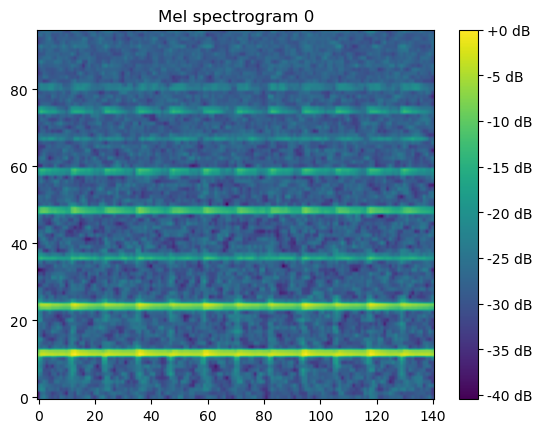

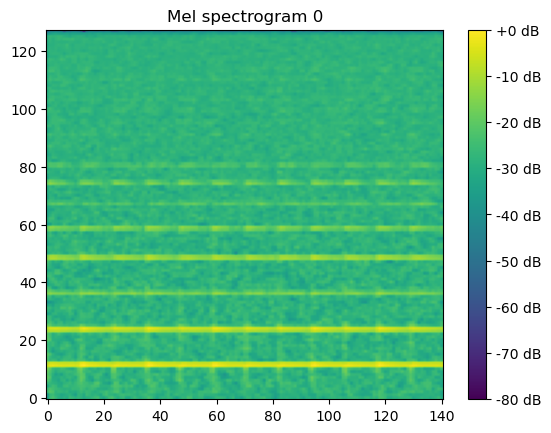

shape of data: (96, 141)


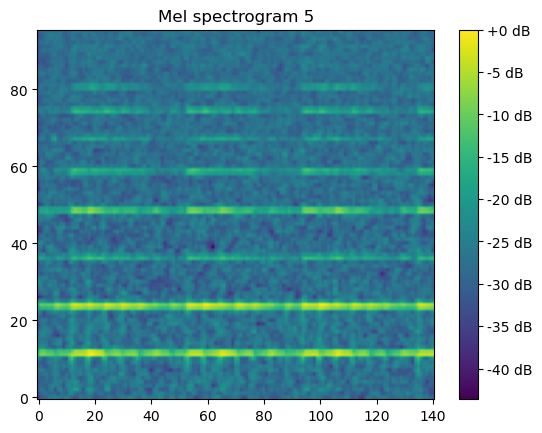

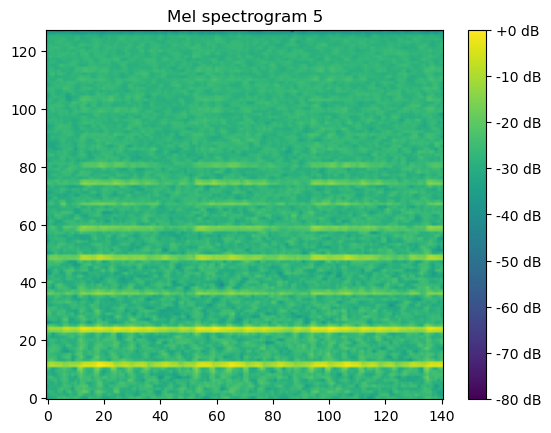

shape of data: (96, 141)


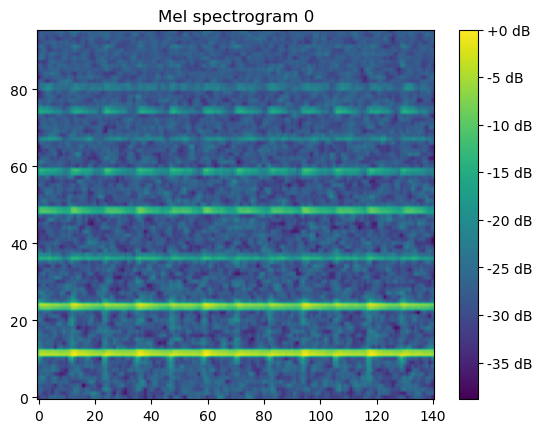

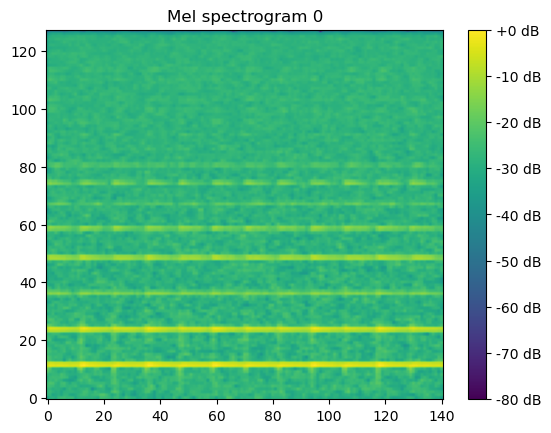

shape of data: (96, 141)


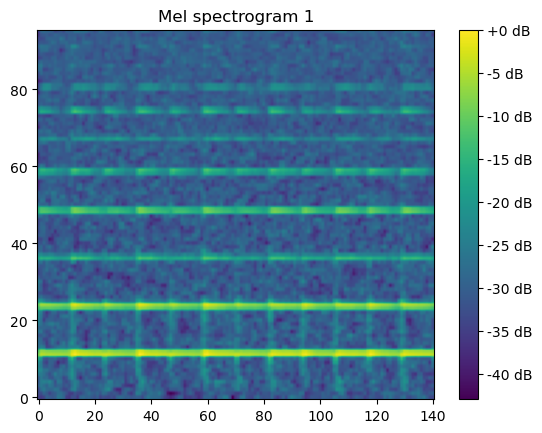

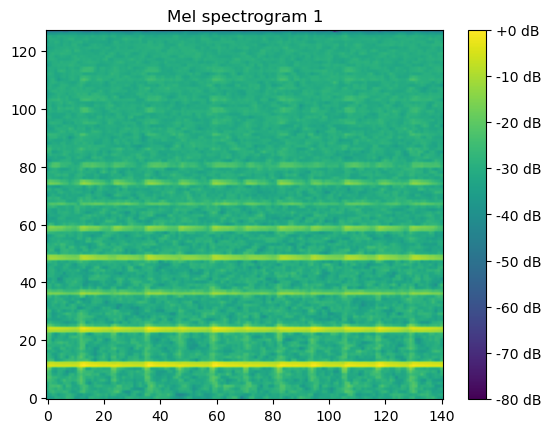

preparing data loaders with batch size 100


In [1]:
# prepare data for snntorch
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random
from torch.utils.data import DataLoader

import snntorch as snn
import torch

sub_dirs = ['1_4', '2_4', '3_4', '4_4', '5_4', '7_8']
CORE_COUNT : int = cpu_count()
num_features = 1  # onset_strength and BPM # pnly onset_strength # surrogate + onset
DIRTY = True
batch_size = 100
onset_padding = 20
FILES_TO_LOAD = 20
SR = 12000

print(f"Number of cores used: {CORE_COUNT}")

def get_length(file_path):
    y, sr = librosa.load(file_path, sr=SR)
    mfccs = librosa.feature.melspectrogram(y=y, sr=sr)
    return mfccs.shape[1]

def determine_fixed_length(directory):
    file_paths = []

    for subdir in sub_dirs:
        files_to_load = os.listdir(os.path.join(directory, subdir))[:FILES_TO_LOAD]
        for file in tqdm(files_to_load):
            file_path = os.path.join(directory, subdir, file)
            file_paths.append(file_path)

    # Utilize multiprocessing for faster computation
    with ProcessPoolExecutor() as executor:
        lengths = list(executor.map(get_length, file_paths))
    
    return min(lengths)

def parallel_data_loader(directories):
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(parallel_load_and_preprocess, directories), total=len(directories)))
    return results

def load_and_preprocess_data_subdir(args):
    directory, subdir = args
    data = []
    labels = []
    
    # Only load up to 20 files per subdirectory
    files_to_load = os.listdir(os.path.join(directory, subdir))[:FILES_TO_LOAD]

    
    for file in files_to_load:
        file_path = os.path.join(directory, subdir, file)
        processed_data = preprocess_audio(file_path)
        data.append(processed_data)
        label = sub_dirs.index(subdir)
        labels.append(label)
    
    return data, labels


def extract_bpm_and_instrument(file_path):
    # Using \d+ to match one or more digits and [\d.]+ to match a float or integer pattern for noise.
    match = re.search(r"instrument_(\d+)_bpm_(\d+)_rotation_\d+_duration_(\d+)_noise_([\d.]+)", file_path)
    if match:
        instrument = match.group(1)
        bpm = match.group(2)
        duration = match.group(3)
        noise = match.group(4)
        return instrument, bpm, duration, noise
    return None, None, None, None

def parallel_load_and_preprocess(directory):
    # Create a pool of processes
    pool = Pool(CORE_COUNT)

    # Create a list of tasks
    tasks = [(directory, time_sig) for time_sig in sub_dirs]

    # Use imap_unordered to distribute the work among the processes
    results = list(tqdm(pool.imap_unordered(load_and_preprocess_data_subdir, tasks), total=len(tasks), mininterval=0.1))

    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    # Combine results
    combined_data = []
    combined_labels = []
    
    for data, labels in results:
        combined_data.extend(data)
        combined_labels.extend(labels)
    
    return combined_data, combined_labels


def adjust_fixed_length(features, timesteps, time_axis=-1):
    """
    Adjust the length of a data array along the specified time axis.

    :param features: The input data array to adjust.
    :param timesteps: The desired length of the time axis.
    :param time_axis: The axis to adjust. Defaults to the last axis.
    :return: The adjusted array.
    """
    if time_axis < 0:
        time_axis = features.ndim + time_axis
    
    # Check if the current length of the time axis matches the desired length
    if features.shape[time_axis] == timesteps:
        return features
    
    # Indices to slice; a full slice for all dimensions
    slicer = [slice(None)] * features.ndim

    # If the current length is greater than the desired length, crop it
    if features.shape[time_axis] > timesteps:
        slicer[time_axis] = slice(0, timesteps)
        return features[tuple(slicer)]
    
    # If the current length is less than the desired length, pad it
    else:
        padding_length = timesteps - features.shape[time_axis]
        pad_widths = [(0, 0) if i != time_axis else (0, padding_length) for i in range(features.ndim)]
        return np.pad(features, pad_widths, mode='constant')


def preprocess_audio(file_path):
    # y, sr = librosa.load(file_path, sr=22050)  # setting sr ensures all files are resampled to this rate
    y, sr = librosa.load(file_path, sr=SR)  # setting sr ensures all files are resampled to this rate
    instrument, bpm = extract_bpm_and_instrument(file_path)

    # Extracting onset strength
    # onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
    # onset_strength_adjusted = adjust_fixed_length(onset_strength, fixed_timesteps)
    # onset_strength_adjusted = onset_strength_adjusted[onset_padding:] # onset strength got weird spikes at the beginning
    # onset_strength_normalized = (onset_strength_adjusted - np.min(onset_strength_adjusted)) / (np.max(onset_strength_adjusted) - np.min(onset_strength_adjusted))
    
    
    # Extracting Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # Adjusting Mel spectrogram length if necessary (similar to onset_strength_adjusted)
    mel_spectrogram_adjusted =  adjust_fixed_length(mel_spectrogram, fixed_timesteps, 1) # adjust as needed
    mel_spectrogram_normalized = (mel_spectrogram_adjusted - np.min(mel_spectrogram_adjusted)) / (np.max(mel_spectrogram_adjusted) - np.min(mel_spectrogram_adjusted))
    
    
    # Extracting BPM (Tempo)
    # tempo, _ = librosa.beat.beat_track(onset_envelope=onset_strength, sr=sr)
    
    # # Normalizing tempo
    # max_tempo = 200.0  # Assume a reasonable max tempo (you may need to adjust this)
    # tempo_normalized = tempo / max_tempo
    
    # # Making it a 2D array to match the dimensions of onset_strength_normalized
    # tempo_feature = np.full((1, onset_strength_normalized.shape[0]), tempo_normalized)
    
    # # Check shapes
    # # print("Onset Strength Shape:", onset_strength_normalized.shape)
    # # print("Tempo Shape:", tempo_feature.shape)
    
    # # Combine onset strength and BPM
    # onset_strength_normalized = onset_strength_normalized.reshape(1, -1)  # reshaping to make it a 2D array
    
    # combined_features = np.vstack([onset_strength_normalized, tempo_feature])
    # num_features +=1
    combined_features = np.vstack(mel_spectrogram_normalized)

    return combined_features


def count_files(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])


# checking shapes
print("Checking shapes...")

training_data_path = 'training_data_dirty_bpm' if DIRTY else 'training_data_clean'
validation_data_path = 'validation_data_dirty_bpm' if DIRTY else 'validation_data_clean'

fixed_timesteps = determine_fixed_length(training_data_path)
print(fixed_timesteps)
# fixed_timesteps2 = determine_fixed_length(validation_data_path)
# print(fixed_timesteps2)
# fixed_timesteps = max(fixed_timesteps, fixed_timesteps2)
# 1. Load and preprocess data
print("Loading and preprocessing training data...")
directories = [training_data_path, validation_data_path]
training_data_results, validation_data_results = parallel_data_loader(directories)

training_data, training_labels = training_data_results
validation_data, validation_labels = validation_data_results
print("\nDone with preprocessing!")

all_data = training_data + validation_data
fixed_timesteps = min([data.shape[0] for data in all_data])
print(f"Fixed timesteps: {fixed_timesteps}")
print(f"shape of training data: {training_data[0].shape}")
print(f"shape of training data: {training_data[0]}")


mel_frequencies = librosa.mel_frequencies(n_mels=all_data[0].shape[0], fmax=SR/2)
index_4kHz = np.argmin(np.abs(mel_frequencies - 3000))
for i in range(0, 4):

    sample_index = np.random.randint(0, len(training_data))
    data = training_data[sample_index][:index_4kHz, :]  # Slice the data
    print(f"shape of data: {data.shape}")
    # librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
    plt.imshow(librosa.power_to_db(data, ref=np.max), origin='lower', aspect='auto')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel spectrogram {training_labels[sample_index]}')
    plt.show()
    # librosa.display.specshow(librosa.power_to_db(training_data[sample_index], ref=np.max), y_axis='mel', x_axis='time')
    plt.imshow(librosa.power_to_db(training_data[sample_index], ref=np.max), origin='lower', aspect='auto')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel spectrogram {training_labels[sample_index]}')
    plt.show()
    # plt.plot(training_data[i])
    # plt.title(f"Random Sample from Normalized Data {training_labels[i]}")
    # plt.show()
    
    
from torch.utils.data import Dataset

class CustomAudioDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors
        sample = torch.tensor(sample, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return sample, label
    
    
print(f"preparing data loaders with batch size {batch_size}")
  
train_dataset = CustomAudioDataset(training_data, training_labels)
test_dataset = CustomAudioDataset(validation_data, validation_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)



torch.Size([50, 128, 141])
torch.Size([50, 128, 141])
training data shape:  (128, 141)


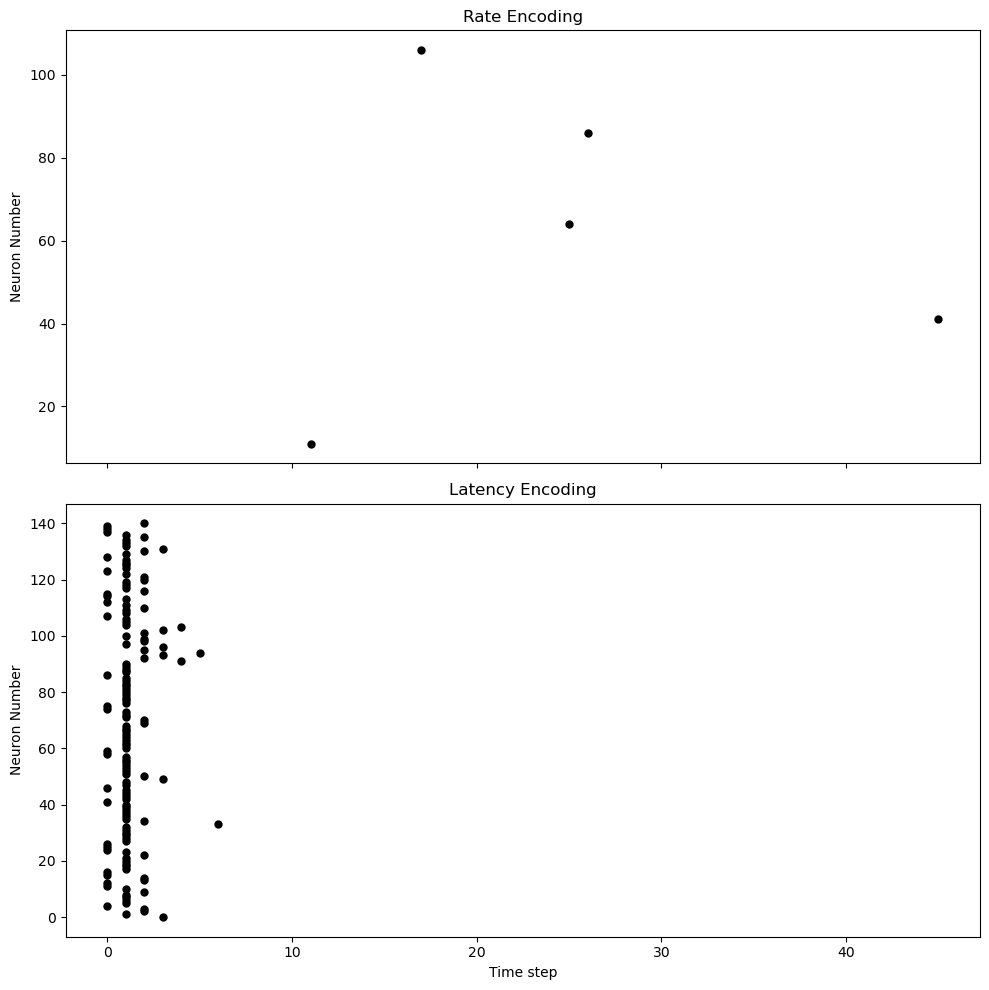

In [26]:
# spike train visualization
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
from snntorch import spikegen


num_steps = 50
tau = 500.0
threshold = 0.0001
clip = True

def convert_to_time(data, tau=tau, threshold=threshold):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

def rate_coding(mel_spec, threshold=0.5):
    spike_data = (mel_spec > threshold).astype(int)
    return spike_data

# Convert list of numpy arrays to a single numpy array
training_data_np = np.array(training_data[0])

# Convert numpy array to PyTorch tensor
raw_input = torch.tensor(training_data_np, dtype=torch.float32)

# spike_times = convert_to_time(raw_input)


# # Step 4: Reduce Dimensionality for Plotting
# plt.plot(raw_input[0, :, 0].numpy(), spike_times[0, :, 0].numpy())
# plt.xlabel('Input Value')
# plt.ylabel('Spike Time (s)')
# plt.show()

# spike_data = spikegen.latency(raw_input, num_steps=num_steps, tau=tau, threshold=threshold, normalize=True, clip=True)
spike_data_rate = spikegen.rate(raw_input, num_steps=num_steps)
spike_data_latency = spikegen.latency(raw_input, num_steps=num_steps, tau=tau, threshold=threshold, normalize=True, clip=False)



print(spike_data_rate.shape)
print(spike_data_latency.shape)
print("training data shape: ", training_data_np.shape)


fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot for Rate Encoding
splt.raster(spike_data_rate[:, 0].view(num_steps, -1), axs[0], s=25, c="black")
axs[0].set_title("Rate Encoding")
axs[0].set_ylabel("Neuron Number")

# Plot for Latency Encoding
splt.raster(spike_data_latency[:, 0].view(num_steps, -1), axs[1], s=25, c="black")
axs[1].set_title("Latency Encoding")
axs[1].set_ylabel("Neuron Number")
axs[1].set_xlabel("Time step")

plt.tight_layout()
plt.show()


In [25]:
# net initialization
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

from snntorch import spikegen

import torch
import torch.nn as nn
from torchvision import datasets, transforms



import matplotlib.pyplot as plt
import numpy as np
import itertools
from IPython.display import clear_output

dtype = torch.float32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


spike_grad = surrogate.fast_sigmoid(slope=25)
# Network Architecture
onset_padding = 20
# num_inputs = num_features * fixed_timesteps - onset_padding
num_inputs = num_features * fixed_timesteps

print(f"Input Layer Size: {num_inputs} Neurons")
num_hidden = 1000
num_outputs = 6

# neuron and simulation parameters
# spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.95
num_steps = 50

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad) # surrogate = bad
        # self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad) # surrogate = bad
        # self.lif2 = snn.Leaky(beta=beta)


    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target


def print_batch_accuracy(data, targets, train=False):
    spike_data_rate = spikegen.rate(data, num_steps=num_steps)
    output, _ = net(spike_data_rate.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    clear_output(wait=True)  # This will clear the output of the cell where the function is called
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")
    
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)


# spike_data_rate = spikegen.rate(data, num_steps=num_steps)

spk_rec, mem_rec = net(data.view(batch_size, -1))

# 50 time steps, 10 samples of data, 4 output neurons
print(mem_rec.size())

# # initialize the total loss value
# loss_val = torch.zeros((1), dtype=dtype, device=device)

# # sum loss at every step
# for step in range(num_steps):
#     loss_val += loss(mem_rec[step], targets)
    
# print(f"Training loss: {loss_val.item():.3f}")
# print_batch_accuracy(data, targets, train=True)

# # clear previously stored gradients
# optimizer.zero_grad()

# # calculate the gradients
# loss_val.backward()

# # weight update
# optimizer.step()


# # calculate new network outputs using the same data
# data, targets = next(iter(train_loader))
# print(f"SNN input shape: {data.shape}")
# spk_rec, mem_rec = net(data.view(batch_size, -1))

# # initialize the total loss value
# loss_val = torch.zeros((1), dtype=dtype, device=device)

# # sum loss at every step
# for step in range(num_steps):
#   loss_val += loss(mem_rec[step], targets)
  

# print(f"Training loss: {loss_val.item():.3f}")

# print_batch_accuracy(data, targets, train=True)

Input Layer Size: 128 Neurons


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x18048 and 128x1000)

# training 1.

In [8]:
# train the network for 10 epochs then plot the loss
num_epochs = 5
loss_hist = []
test_loss_hist = []
counter = 0
tau = 5
threshold = 0.3   
clip = True

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spike_data_rate = spikegen.rate(data, num_steps=num_steps)

        # # Latency encoding
        # input_latency_encoded = spikegen.latency(data, num_steps=num_steps, tau=tau, threshold=threshold, normalize=True, clip=clip)
        # print(input_latency_encoded.shape)
        
        # # feed data into the network
        # spk_rec, mem_rec = net(input_latency_encoded.view(batch_size, -1))
        spk_rec, mem_rec = net(spike_data_rate.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 10 == 0:
                train_printer()
            counter += 1
            iter_counter +=1
            
plt.title(f"Training Loss, Batch Size: {batch_size}")
plt.plot(loss_hist, label="Training Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x902400 and 128x1000)

In [ ]:
# adjust batchsize if needed
batch_size = 200

  
train_dataset = CustomAudioDataset(training_data, training_labels)
test_dataset = CustomAudioDataset(validation_data, validation_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Epoch 9, Iteration 13
Train Set Loss: 11.34
Test Set Loss: 14.96
Train set accuracy for a single minibatch: 85.16%
Test set accuracy for a single minibatch: 84.38%




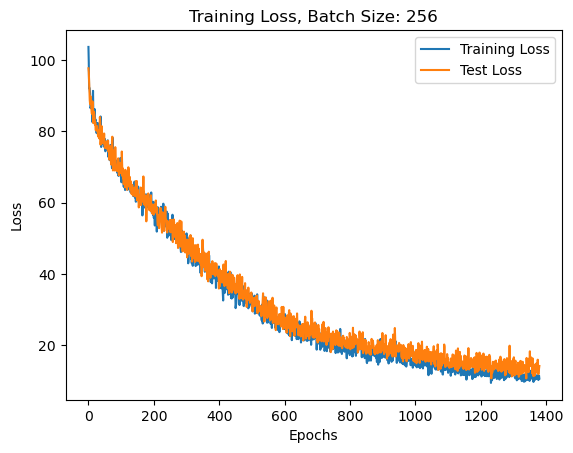

In [ ]:
# second training if needed
num_epochs = 50

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 10 == 0:
                train_printer()
            counter += 1
            iter_counter +=1
            
plt.title(f"Training Loss, Batch Size: {batch_size}")           
plt.plot(loss_hist, label="Training Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch [0/50]: Train Loss: 89.9235, Test Loss: 88.3255
Epoch [10/50]: Train Loss: 63.8685, Test Loss: 66.1130
Epoch [20/50]: Train Loss: 56.6981, Test Loss: 61.2474
Epoch [30/50]: Train Loss: 45.6729, Test Loss: 44.4552
Epoch [40/50]: Train Loss: 36.5912, Test Loss: 39.5782


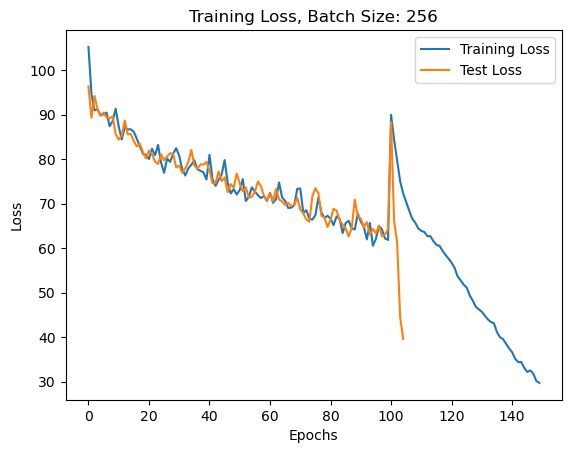

In [172]:
# fast training
num_epochs = 50

# Set the model to training mode before starting the training loop
net.train()

# Outer training loop
for epoch in range(num_epochs):
    total_loss = 0.0  # to keep track of total loss for each epoch
    
    # Minibatch training loop
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        total_loss += loss_val.item()

    # average loss for this epoch
    loss_hist.append(total_loss / len(train_loader))

    # Test set
    if epoch % 10 == 0:  # Test every 10 epochs; adjust based on your preference
        net.eval()
        with torch.no_grad():
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

        net.train()  # Switch back to training mode after testing

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}]: Train Loss: {total_loss / len(train_loader):.4f}, Test Loss: {test_loss.item():.4f}")

plt.title(f"Training Loss, Batch Size: {batch_size}")           
plt.plot(loss_hist, label="Training Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

eval

SNN - Total correctly classified test set images: 5613/6000
 Test Set Accuracy: 93.55% after training 50 epochs


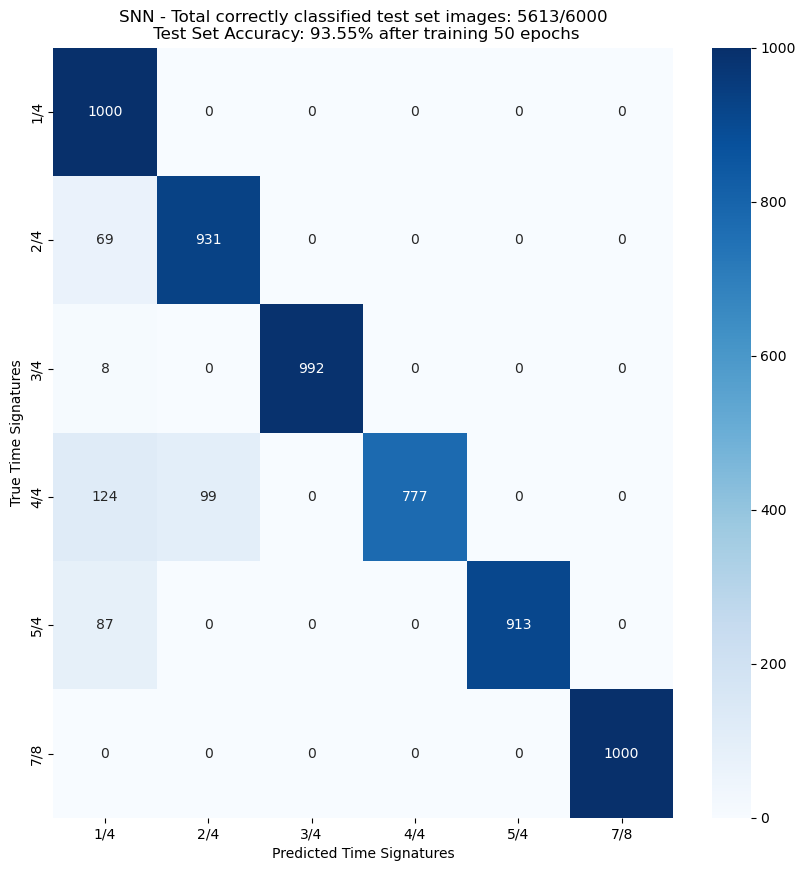

In [22]:
# evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

confidence_threshold = 0.0  # Set your confidence threshold


total = 0
correct = 0

true_labels = []
predicted_labels = []
predicted_percentages = []

# drop_last switched to False to keep all samples
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # Calculate spike sums and get the maximum across neurons for each example
        spike_sums = test_spk.sum(dim=0)
        _, predicted = spike_sums.max(1)

        # Normalize spike sums to get "confidence percentages"
        spike_sums = (spike_sums / spike_sums.sum(dim=1, keepdim=True)) * 100
        predicted_percentage = spike_sums[np.arange(spike_sums.shape[0]), predicted].cpu().numpy()
        # Skip low-confidence predictions
        for i in range(len(predicted)):
            if predicted_percentage[i] < confidence_threshold:
                continue
            total += 1
            correct += (predicted[i] == targets[i]).item()
            true_labels.append(targets[i].item())
            predicted_labels.append(predicted[i].item())
            predicted_percentages.append(predicted_percentage[i])
    

result = f"SNN - Total correctly classified test set images: {correct}/{total}\n Test Set Accuracy: {100 * correct / total:.2f}% after training {num_epochs} epochs"
print(result)


# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define your custom labels
custom_labels = ['1/4', '2/4', '3/4', '4/4', '5/4', '7/8']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 10))
plt.title(result)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=custom_labels, yticklabels=custom_labels)
plt.xlabel('Predicted Time Signatures')
plt.ylabel('True Time Signatures')
plt.show()

save the net

In [50]:
# Save model state_dict
torch.save(net.state_dict(), f"snn_hidden{num_hidden}_{100 * correct / total:.2f}.pth")

# CNN

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

def conv1d_out_size(W_in, K, P=0, S=1):
    return (W_in - K + 2*P) // S + 1

def maxpool1d_out_size(W_in, K, S):
    return (W_in - K) // S + 1

# Define CNN model
class CNN(nn.Module):
    def __init__(self, input_width=239):
        super(CNN, self).__init__()
        
        # Convolutional layer properties
        self.conv1_in_channels = 1 # 1 channel for mono audio
        self.conv1_out_channels = 32
        self.conv1_kernel_size = 5
        self.conv1_stride = 1
        self.conv1_padding = 2
        
        # Pooling layer properties
        self.pool_kernel_size = 2
        self.pool_stride = 2
        
        # Calculated convolutional output width
        self.conv1_out_width = self.conv1d_out_size(input_width, self.conv1_kernel_size, self.conv1_padding, self.conv1_stride)
        # Calculated pooling output width
        self.pool_out_width = self.maxpool1d_out_size(self.conv1_out_width, self.pool_kernel_size, self.pool_stride)
        
        # Define layers
        self.conv1 = nn.Conv1d(self.conv1_in_channels, self.conv1_out_channels, kernel_size=self.conv1_kernel_size, stride=self.conv1_stride, padding=self.conv1_padding)
        self.pool = nn.MaxPool1d(self.pool_kernel_size, stride=self.pool_stride)
        self.fc1 = nn.Linear(self.conv1_out_channels * self.pool_out_width, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, self.conv1_out_channels * self.pool_out_width)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def conv1d_out_size(self, W_in, K, P=0, S=1):
        return (W_in - K + 2*P) // S + 1

    def maxpool1d_out_size(self, W_in, K, S):
        return (W_in - K) // S + 1

# Assuming `train_loader` and `test_loader` are your data loaders
train_dataset = CustomAudioDataset(training_data, training_labels)
test_dataset = CustomAudioDataset(validation_data, validation_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize CNN model and loss function
cnn_model = CNN(num_inputs)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=5e-4)

EPOCH_CNT = 50
# Training Loop
for epoch in range(EPOCH_CNT):  # 10 epochs; you can change this
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass

        reshaped_data = data.view(batch_size, 1, num_inputs)
        outputs = cnn_model(reshaped_data)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:  # Print loss every 10 batches
            print(f'\nEpoch [{epoch+1}/{EPOCH_CNT}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}', end="\r")

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        reshaped_data = data.view(batch_size, 1, num_inputs)  # reshape to fit into CNN

        outputs = cnn_model(reshaped_data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Accuracy of the CNN on test set: {100 * correct / total}%')


torch.Size([200, 1, 239])
torch.Size([200, 1, 239]), Loss: 1.7899
torch.Size([200, 1, 239])], Loss: 1.7372
torch.Size([200, 1, 239])], Loss: 1.5972
torch.Size([200, 1, 239]), Loss: 1.4242
torch.Size([200, 1, 239])], Loss: 1.3062
torch.Size([200, 1, 239])], Loss: 1.3111
torch.Size([200, 1, 239]), Loss: 1.2233
torch.Size([200, 1, 239])], Loss: 1.1639
torch.Size([200, 1, 239])], Loss: 1.0960
torch.Size([200, 1, 239]), Loss: 1.0828
torch.Size([200, 1, 239])], Loss: 1.0466
torch.Size([200, 1, 239])], Loss: 1.0605
torch.Size([200, 1, 239]), Loss: 1.0092
torch.Size([200, 1, 239])], Loss: 1.0366
torch.Size([200, 1, 239])], Loss: 1.0053
torch.Size([200, 1, 239]), Loss: 0.9100
torch.Size([200, 1, 239])], Loss: 0.9701
torch.Size([200, 1, 239])], Loss: 0.9408
torch.Size([200, 1, 239]), Loss: 1.0624
torch.Size([200, 1, 239])], Loss: 0.9430
torch.Size([200, 1, 239])], Loss: 1.0414
torch.Size([200, 1, 239]), Loss: 0.9645
torch.Size([200, 1, 239])], Loss: 0.9698
torch.Size([200, 1, 239])], Loss: 0.869

In [116]:
EPOCH_CNT = 10
# Training Loop
for epoch in range(EPOCH_CNT):  # 10 epochs; you can change this
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        reshaped_data = data.view(batch_size, 1, num_inputs)  # reshape to fit into CNN

        outputs = cnn_model(reshaped_data)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:  # Print loss every 10 batches
            print(f'Epoch [{epoch+1}/{EPOCH_CNT}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}', end="\r")

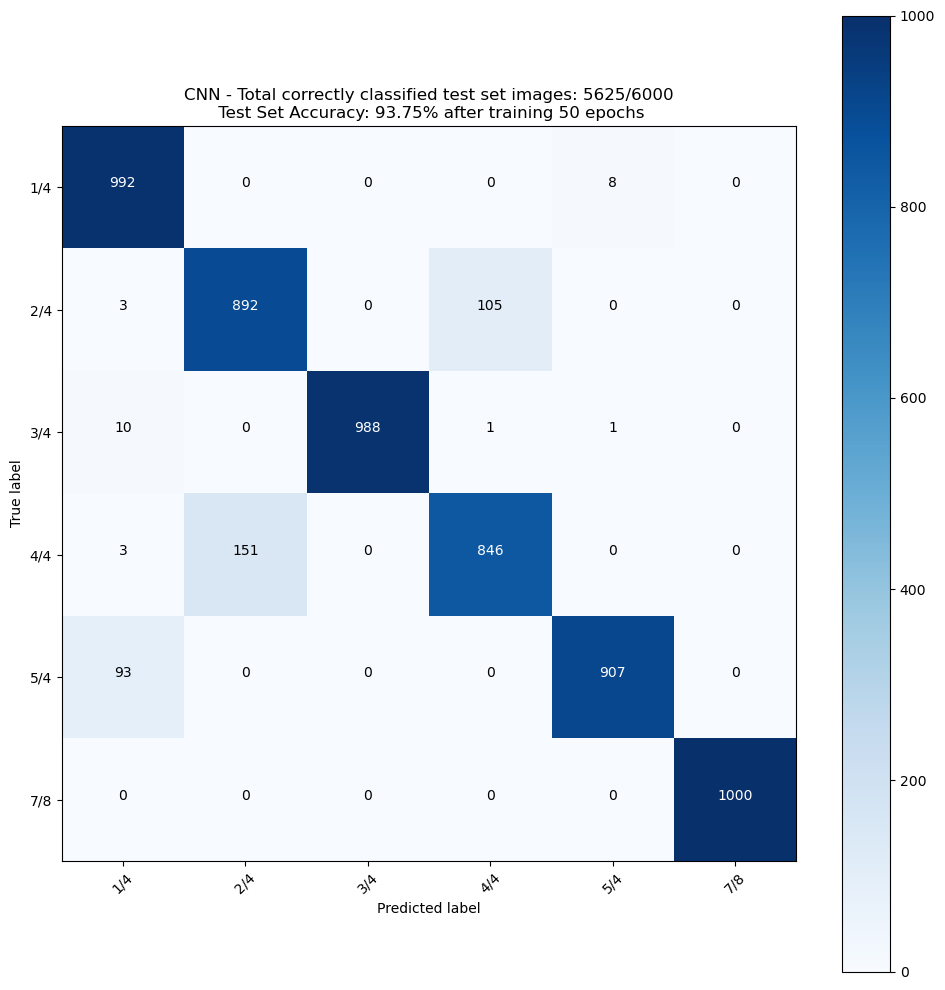

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

all_targets = []
all_predicted = []

correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        reshaped_data = data.view(batch_size, 1, num_inputs)  # reshape to fit into CNN
        outputs = cnn_model(reshaped_data)
        _, predicted = torch.max(outputs, 1)
        all_targets.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

        total += target.size(0)
        correct += (predicted == target).sum().item()


cm = confusion_matrix(all_targets, all_predicted)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Add overall accuracy to the plot
    overall_accuracy = np.trace(cm) / np.sum(cm)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
result = f"CNN - Total correctly classified test set images: {correct}/{total}\n Test Set Accuracy: {100 * correct / total:.2f}% after training {EPOCH_CNT} epochs"
# Use your confusion matrix (cm) and class names here
class_names = ['1/4', '2/4', '3/4', '4/4', '5/4', '7/8']
plot_confusion_matrix(cm, classes=class_names, title=result)

In [28]:
# Compare CNN and SNN latency
import time

batchsize = 1000
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True, drop_last=True)

cnt = 0
t = 1

# Tracking time for CNN
cnn_model.eval()
cumulative_time_cnn = 0.0
for i in range(t):
    for batch_idx, (data, target) in enumerate(test_loader):
        reshaped_data = data.view(batchsize, 1, num_inputs)  # reshape outside the timer
        
        start_time = time.time()
        outputs = cnn_model(reshaped_data)
        end_time = time.time()

        cumulative_time_cnn += (end_time - start_time)
        cnt += 1

print(f"Latency CNN: {cumulative_time_cnn:.2f} seconds for {cnt} batches and {batchsize*cnt} samples")

# Tracking time for SNN
cnt = 0
net.eval()
cumulative_time_snn = 0.0
for i in range(t):
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            reshaped_data = data.view(data.size(0), -1)
            # Start timing
            start_time = time.time()
            test_spk, _ = net(reshaped_data)
            end_time = time.time()
            
            cumulative_time_snn += (end_time - start_time)
            cnt += 1

print(f"Latency SNN: {cumulative_time_snn:.2f} seconds for {cnt} batches and {batchsize*cnt} samples")


Latency CNN: 0.35 seconds for 6 batches and 6000 samples
Latency SNN: 2.83 seconds for 6 batches and 6000 samples
